# Boosting Black Box Variational Inference
## Introduction
This tutorial demonstrates how to implement boosting black box Variational Inference [1] in Pyro. In boosting Variational Inference [2], we approximate a target distribution with an iteratively selected mixture of densities. In cases where a single denisity provided by regular Variational Inference doesn't adequately approximate a target density, boosting VI thus offers a simple way of getting more complex approximations. We show how this can be implemented as a relatively straightforward extension of Pyro's SVI.

## Contents
* [Theoretical Background](#theoretical-background)
    - [Variational Inference](#variational-inference)
    - [Boosting Black Box Variational Inference](#bbbvi)
* [BBBVI in Pyro](#bbbvi-pyro)
    - [The Model](#the-model)
    - [The Guide](#the-guide)
    - [The Relbo](#the-relbo)
    - [The Approximation](#the-approximation)
    - [The Greedy Algorithm](#the-greedy-algorithm)

## Theoretical Background <a class="anchor" id="theoretical-background"></a>

### Variational Inference <a class="anchor" id="variational-inference"></a>
For an introduction to regular Variational Inference, we recommend having a look at [the tutorial on SVI in Pyro](https://pyro.ai/examples/svi_part_i.html) and this excellent review [3].

Briefly, Variational Inference allows us to find approximations of probability densities which are intractable to compute analytically. For instance, one might have observed variables $\textbf{x}$, latent variables $\textbf{z}$ and a joint distribution $p(\textbf{x}, \textbf{z})$. One can then use Variational Inference to approximate $p(\textbf{z}|\textbf{x})$. To do so, one first chooses a set of tractable densities, a variational family, and then tries to find the element of this set which most closely approximates the target distribution $p(\textbf{z}|\textbf{x})$.
This approximating density is found by maximizing the Evidence Lower BOund (ELBO):
$$ \mathbb{E}_q[\log p(\mathbf{x}, \mathbf{z})] - \mathbb{E}_q[\log q(\mathbf{z})]$$

where $s(\mathbf{z})$ is the approximating density.

### Boosting Black Box Variational Inference <a class="anchor" id="bbbvi"></a>

In boosting black box Variational inference (BBBVI), we approximate the target density with a mixture of densities from the variational family:
$$q^t(\mathbf{z}) = \sum_{i=1}^t \gamma_i s_i(\mathbf{z})$$

$$\text{where} \sum_{i=1}^t \gamma_i =1$$

and $s_t(\mathbf{z})$ are elements of the variational family.

The components of the approximation are selected greedily by maximising the so-called Residual ELBO (RELBO) with respect to the next component $s_{t+1}(\mathbf{z})$:

$$\mathbb{E}_s[\log p(\mathbf{x},\mathbf{z})] - \lambda \mathbb{E}_s[\log s(\mathbf{z})] - \mathbb{E}_s[\log q^t(\mathbf{z})]$$

Where the first two terms are the same as in the ELBO and the last term is the cross entropy between the next component $s_{t+1}(\mathbf{z})$ and the current approximation $q^t(\mathbf{z})$.

It's called *black box* Variational Inference because this optimization does not have to be tailored to the variational family which is being used. By setting $\lambda$ (the regularization factor of the entropy term) to 1, standard SVI methods can be used to compute $\mathbb{E}_s[\log p(\mathbf{x}, \mathbf{z})] - \lambda \mathbb{E}_s[\log s(\mathbf{z})]$. See the explanation of [the section on the implementation of the RELBO](#the-relbo) below for an explanation of how we compute the term  $- \mathbb{E}_s[\log q^t(\mathbf{z})]$. Imporantly, we do not need to make any additional assumptions about the variational family that's being used to ensure that this algorithm converges. 

In [1], a number of different ways of finding the mixture weights $\gamma_t$ are suggested, ranging from fixed step sizes based on the iteration to solving the optimisation problem of finding $\gamma_t$ that will minimise the RELBO. Here, we used the fixed step size method.
For more details on the theory behind boosting black box variational inference, please refer to [1].

## BBBVI in Pyro <a class="anchor" id="bbbvi-pyro"></a>

To implement boosting black box variational inference in Pyro, we need to consider the following points:
1. The approximation components $s_{t}(\mathbf{z})$ (guides).
2. The RELBO.
3. The approximation itself $q^t(\mathbf{z})$.
4. Using Pyro's SVI to find new components of the approximation.

We will illustrate these points by looking at simple example: approximating a bimodal posterior.


In [26]:
import os
from collections import defaultdict
from functools import partial

import numpy as np
import pyro
import pyro.distributions as dist
import scipy.stats
import torch
import torch.distributions.constraints as constraints
from matplotlib import pyplot
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.poutine import block, replay, trace


### The Model <a class="anchor" id="the-model"></a>

Boosting BBVI is particularly useful when we want to approximate mulitmodal distributions. In this tutorial, we'll thus consider the following model:
 
 $$\mathbf{z} \sim \mathcal{N}(0,5)$$
 $$\mathbf{x} \sim \mathcal{N}(\mathbf{z}^2, 0.1)$$
 
Given the set of iid. observations $\text{data} ~ \mathcal{N}(4, 0.1)$, we thus expect $p(\mathbf{z}|\mathbf{x})$ to be a bimodal distributions with modes around $-2$ and $2$.
 
In Pyro, this model takes the following shape:

In [23]:
def model(data):
    prior_loc = torch.tensor([0.])
    prior_scale = torch.tensor([5.])
    z = pyro.sample('z', dist.Normal(prior_loc, prior_scale))
    scale = torch.tensor([0.1])

    with pyro.plate('data', len(data)):
        pyro.sample('x', dist.Normal(z*z, scale), obs=data)

### The Guide <a class="anchor" id="the-guide"></a>

Next, we specify the guide which in our case will make up the components of our mixture. Recall that in Pyro the guide needs to take the same arguments as the model which is why our guide function also takes the data as an input. 

We also need to make sure that every `pyro.sample()` statement from the model has a matching `pyro.sample()` statement in the guide. In our case, we include `loc` in both the model and the guide.

In contrast to regular SVI, our guide takes an additional argument: `index`. Having this argument allows us to easily create new guides in each iteration of the greedy algorithm. Specifically, we make use of `partial()` from the [functools library](https://docs.python.org/3.7/library/functools.html) to create guides which only take `data` as an argument. The statement `partial(guide, index=t)` creates a guide that will take only `data` as an input and which has trainable parameters `scale_t` and `loc_t`.

Choosing our variational distribution to be a Normal distribution parameterized by $loc_t$ and $scale_t$ we get the following guide:

In [6]:
def guide(data, index):
    scale_q = pyro.param('scale_{}'.format(index), torch.tensor([1.0]), constraints.positive)
    loc_q = pyro.param('loc_{}'.format(index), torch.tensor([0.0]))
    pyro.sample("z", dist.Normal(loc_q, scale_q))

### The RELBO <a class="anchor" id="the-relbo"></a>

We implement the RELBO as a function which can be passed to Pyro's SVI class in place of ELBO to find the approximation components $s_t(z)$. Recall that the RELBO has the following form:
$$\mathbb{E}_s[\log p(\mathbf{x},\mathbf{z})] - \lambda \mathbb{E}_s[\log s(\mathbf{z})] - \mathbb{E}_s[\log q^t(\mathbf{z})]$$

Conveniently, this is very similar to the regular ELBO which allows us to reuse Pyro's existing ELBO. Specifically, we compute 
$$\mathbb{E}_s[\log p(x,z)] - \lambda \mathbb{E}_s[\log s]$$
using Pyro's `Trace_ELBO` and then compute 
$$ - \mathbb{E}_s[\log q^t]$$
using Poutine. For more information on how this works, we recommend going through the Pyro tutorials [on Poutine](https://pyro.ai/examples/effect_handlers.html) and [custom SVI objectives](https://pyro.ai/examples/custom_objectives.html).

In [19]:
def relbo(model, guide, *args, **kwargs):

    approximation = kwargs.pop('approximation', None)
    # Run the guide with the arguments passed to SVI.step() and trace the execution,
    # i.e. record all the calls to Pyro primitives like sample() and param().
    guide_trace = trace(guide).get_trace(*args, **kwargs)

    # We do not want to update parameters of previously fitted components and thus block all
    # parameters in the approximation apart from z.
    replayed_approximation = trace(replay(block(approximation, expose=['z']), guide_trace))
    approximation_trace = replayed_approximation.get_trace(*args, **kwargs)

    loss_fn = pyro.infer.Trace_ELBO(max_plate_nesting=1).differentiable_loss(model,
                                                                             guide,
                                                                             *args,
                                                                             **kwargs)

    relbo = -loss_fn - approximation_trace.log_prob_sum()
    
    # By convention, the negative (R)ELBO is returned.
    return -relbo

### The Approximation <a class="anchor" id="the-approximation"></a>

Our implementation of the approximation $q^t(z) = \sum_{i=1}^t \gamma_i s_i(z)$ consists of a list of components, i.e. the guides from the greedy selection steps, and a list containing the mixture weights of the components. To sample from the approximation, we thus first sample a component according to the mixture weights. In a second step, we draw a sample from the corresponding component.

Similarly as with the guide, we use `partial(approximation, components=components, weights=weights)` to get an approximation function which has the same signature as the model.

In [169]:
def approximation(data, components, weights):
    assignment = pyro.sample('assignment', dist.Categorical(weights))
    result = components[assignment](data)
    return result        

### The Greedy Algorithm <a class="anchor" id="the-greedy-algorithm"></a>

We now have all the necessary parts to implement the greedy algorithm. First, we initialize the approximation:

In [88]:
initial_approximation = partial(guide, index=0)
components = [initial_approximation]
weights = torch.tensor([1.])
wrapped_approximation = partial(approximation, components=components, weights=weights)

Then we iteratively find the $T$ components of the approximation by maximizing the RELBO at every step:

In [ ]:
# clear the param store in case we're in a REPL
pyro.clear_param_store()

# Sample observations from a Normal distribution with loc 4 and scale 0.1
n = torch.distributions.Normal(torch.tensor([4.0]), torch.tensor([0.1]))
data = n.sample((100,))

#T=2
n_steps = 2 if smoke_test else 12000
pyro.set_rng_seed(2)
n_iterations = 2
locs = [0]
scales = [0]
for t in range(1, n_iterations + 1):

    # Create guide that only takes data as argument
    wrapped_guide = partial(guide, index=t)
    losses = []

    adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
    optimizer = Adam(adam_params)

    # Pass our custom RELBO to SVI as the loss function.
    svi = SVI(model, wrapped_guide, optimizer, loss=relbo)
    for step in range(n_steps):
        # Pass the existing approximation to SVI.
        loss = svi.step(data, approximation=wrapped_approximation)
        losses.append(loss)

        if step % 100 == 0:
            print('.', end=' ')

    # Update the list of approximation components.
    components.append(wrapped_guide)

    # Set new mixture weight.
    new_weight = 2 / (t + 1)

    # In this specific case, we set the mixture weight of the second component to 0.5.
    if t == 2:
        new_weight = 0.5
    weights = weights * (1-new_weight)
    weights = torch.cat((weights, torch.tensor([new_weight])))

    # Update the approximation
    wrapped_approximation = partial(approximation, components=components, weights=weights)

    print('Parameters of component {}:'.format(t))
    scale = pyro.param("scale_{}".format(t)).item()
    scales.append(scale)
    loc = pyro.param("loc_{}".format(t)).item()
    locs.append(loc)
    print('loc = {}'.format(loc))
    print('scale = {}'.format(scale))

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Parameters of component 1:
loc = -1.9934829473495483
scale = 0.020978907123208046
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [ ]:
# Plot the resulting approximation
X = np.arange(-10, 10, 0.1)
pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
total_approximation = np.zeros(X.shape)
for i in range(1, n_iterations + 1):
    Y = weights[i].item() * scipy.stats.norm.pdf((X - locs[i]) / scales[i])
    pyplot.plot(X, Y)
    total_approximation += Y
pyplot.plot(X, total_approximation)
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Approximation of posterior over z')
pyplot.ylabel('probability density')
pyplot.show()

We see that boosting BBVI successfully approximates the bimodal posterior distributions with modes around -2 and +2.

## The Complete Implementation

Putting all the components together, we then get the complete implementation of boosting black box Variational Inference:

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Parameters of component 1:
loc = -1.9950288534164429
scale = 0.038874927908182144
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Parameters of component 2:
loc = 2.009120225906372
scale = 0.01808810420334339


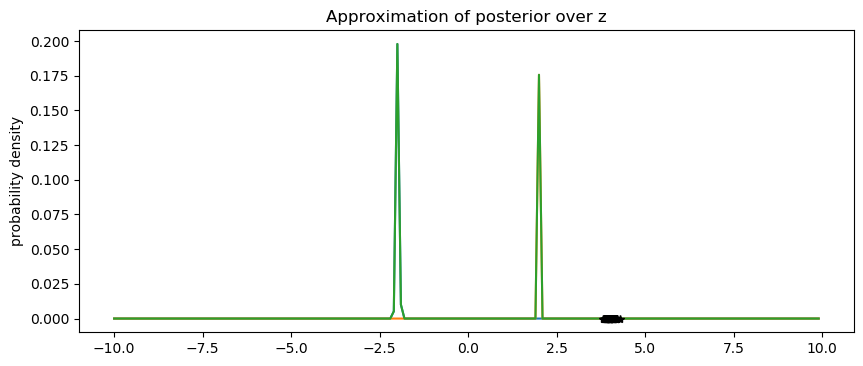

In [74]:
import os
from collections import defaultdict
from functools import partial

import numpy as np
import pyro
import pyro.distributions as dist
import scipy.stats
import torch
import torch.distributions.constraints as constraints
from matplotlib import pyplot
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.poutine import block, replay, trace

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 12000
pyro.set_rng_seed(2)

# enable validation (e.g. validate parameters of distributions)
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# Sample observations from a Normal distribution with loc 4 and scale 0.1
n = torch.distributions.Normal(torch.tensor([4.0]), torch.tensor([0.1]))
data = n.sample((100,))


def guide(data, index):
    scale_q = pyro.param('scale_{}'.format(index), torch.tensor([1.0]), constraints.positive)
    loc_q = pyro.param('loc_{}'.format(index), torch.tensor([0.0]))
    pyro.sample("z", dist.Normal(loc_q, scale_q))


def model(data):
    prior_loc = torch.tensor([0.])
    prior_scale = torch.tensor([5.])
    z = pyro.sample('z', dist.Normal(prior_loc, prior_scale))
    scale = torch.tensor([0.1])

    with pyro.plate('data', len(data)):
        pyro.sample('x', dist.Normal(z*z, scale), obs=data)


def relbo(model, guide, *args, **kwargs):

    approximation = kwargs.pop('approximation', None)
    # Run the guide with the arguments passed to SVI.step() and trace the execution,
    # i.e. record all the calls to Pyro primitives like sample() and param().
    guide_trace = trace(guide).get_trace(*args, **kwargs)

    # We do not want to update parameters of previously fitted components and thus block all
    # parameters in the approximation apart from z.
    replayed_approximation = trace(replay(block(approximation, expose=['z']), guide_trace))
    approximation_trace = replayed_approximation.get_trace(*args, **kwargs)

    loss_fn = pyro.infer.Trace_ELBO(max_plate_nesting=1).differentiable_loss(model,
                                                                             guide,
                                                                             *args,
                                                                             **kwargs)

    relbo = -loss_fn - approximation_trace.log_prob_sum()
    
    # By convention, the negative (R)ELBO is returned.
    return -relbo


def approximation(data, components, weights):
    assignment = pyro.sample('assignment', dist.Categorical(weights))
    result = components[assignment](data)
    return result


def boosting_bbvi():
    # T=2
    n_iterations = 2
    initial_approximation = partial(guide, index=0)
    components = [initial_approximation]
    weights = torch.tensor([1.])
    wrapped_approximation = partial(approximation, components=components, weights=weights)

    locs = [0]
    scales = [0]

    for t in range(1, n_iterations + 1):
        
        # Create guide that only takes data as argument
        wrapped_guide = partial(guide, index=t)
        losses = []

        adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
        optimizer = Adam(adam_params)

        # Pass our custom RELBO to SVI as the loss function.
        svi = SVI(model, wrapped_guide, optimizer, loss=relbo)
        for step in range(n_steps):
            # Pass the existing approximation to SVI.
            loss = svi.step(data, approximation=wrapped_approximation)
            losses.append(loss)

            if step % 100 == 0:
                print('.', end=' ')

        # Update the list of approximation components.
        components.append(wrapped_guide)
        
        # Set new mixture weight.
        new_weight = 2 / (t + 1)

        # In this specific case, we set the mixture weight of the second component to 0.5.
        if t == 2:
            new_weight = 0.5
        weights = weights * (1-new_weight)
        weights = torch.cat((weights, torch.tensor([new_weight])))

        # Update the approximation
        wrapped_approximation = partial(approximation, components=components, weights=weights)

        print('Parameters of component {}:'.format(t))
        scale = pyro.param("scale_{}".format(t)).item()
        scales.append(scale)
        loc = pyro.param("loc_{}".format(t)).item()
        locs.append(loc)
        print('loc = {}'.format(loc))
        print('scale = {}'.format(scale))


    # Plot the resulting approximation
    X = np.arange(-10, 10, 0.1)
    pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
    total_approximation = np.zeros(X.shape)
    for i in range(1, n_iterations + 1):
        Y = weights[i].item() * scipy.stats.norm.pdf((X - locs[i]) / scales[i])
        pyplot.plot(X, Y)
        total_approximation += Y
    pyplot.plot(X, total_approximation)
    pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
    pyplot.title('Approximation of posterior over z')
    pyplot.ylabel('probability density')
    pyplot.show()

if __name__ == '__main__':
    boosting_bbvi()


### References

[1] Locatello, Francesco, et al. "Boosting black box variational inference." Advances in Neural Information Processing Systems. 2018.

[2] Ranganath, Rajesh, Sean Gerrish, and David Blei. "Black box variational inference." Artificial Intelligence and Statistics. 2014.

[3] Blei, David M., Alp Kucukelbir, and Jon D. McAuliffe. "Variational inference: A review for statisticians." Journal of the American statistical Association 112.518 (2017): 859-877.